In [1]:
using DrWatson
@quickactivate("Hierarchical_Infer_Spikes")

using HiddenMarkovModels, CSV, StatsPlots, DataFrames, Distributions, Random, LinearAlgebra

# this data was checked graphically to see that the spike counts in the delay zone match
# their assigned positions and that the outcome of the trial comes AFTER these spikes occur
data = CSV.File(datadir("exp_raw","delay_spike_rate.csv"),header=1)|> DataFrame
data[!,"Animal"] = [findfirst(isequal(d),[2443,2453,2454,2462,2467,2486,149]) for d in data.Animal]
data[!,"Day"] = [findfirst(isequal(d),["D1","D2","D3","D4","D5"]) for d in data.Day]
times = data[:,6] |> Vector;
data = data[:,1:5] |> Matrix;
Random.seed!(1234)


# this data was checked graphically to see that the spike counts in the delay zone match
# their assigned positions and that the outcome of the trial comes AFTER these spikes occur
data_BIRDS = CSV.File(datadir("exp_raw","delay_spike_rate_solitary_and_first.csv"),header=1)|> DataFrame
data_BIRDS[!,"Animal"] = [findfirst(isequal(d),[2443,2453,2454,2462,2467,2486,149]) for d in data_BIRDS.Animal]
data_BIRDS[!,"Day"] = [findfirst(isequal(d),["D1","D2","D3","D4","D5"]) for d in data_BIRDS.Day]
times_BIRDs = data_BIRDS[:,6] |> Vector;
data_BIRDs = data_BIRDS[:,1:5] |> Matrix;

In [13]:
N_states = 3 # N = 2 FAILS both posterior predictive checks on the mean spike count (ie model predicts wrong mean spike counts for its vitebri best guess)
init = ones(N_states)/N_states
trans = (I(N_states) .+ 0.5*ones(N_states))
trans = trans./sum(trans,dims=2)

dists = [Bernoulli(p) for p in LinRange(0.1, 0.9, N_states)]
hmm = HMM(init, trans, dists)

days = unique(data[:,2])
animals = unique(data[:,1])
seq_ends = sort(findlast.([(data[:,2].==d .&& data[:,1] .== a for d in days for a in animals)...]))

est_hmm,ll = baum_welch(hmm, data[:,3];seq_ends)
guess,ll_fb = forward_backward(est_hmm, data[:,3];seq_ends)
guess_vit,ll_vit = viterbi(est_hmm, data[:,3];seq_ends)
obs_distributions(est_hmm)

3-element Vector{Bernoulli{Float64}}:
 Bernoulli{Float64}(p=0.19370641217206708)
 Bernoulli{Float64}(p=0.5348580251277684)
 Bernoulli{Float64}(p=0.7500068027483867)

In [14]:
last(ll) # also try this for N = 2!

-323.4656252715288

## Reproduce Figure S3

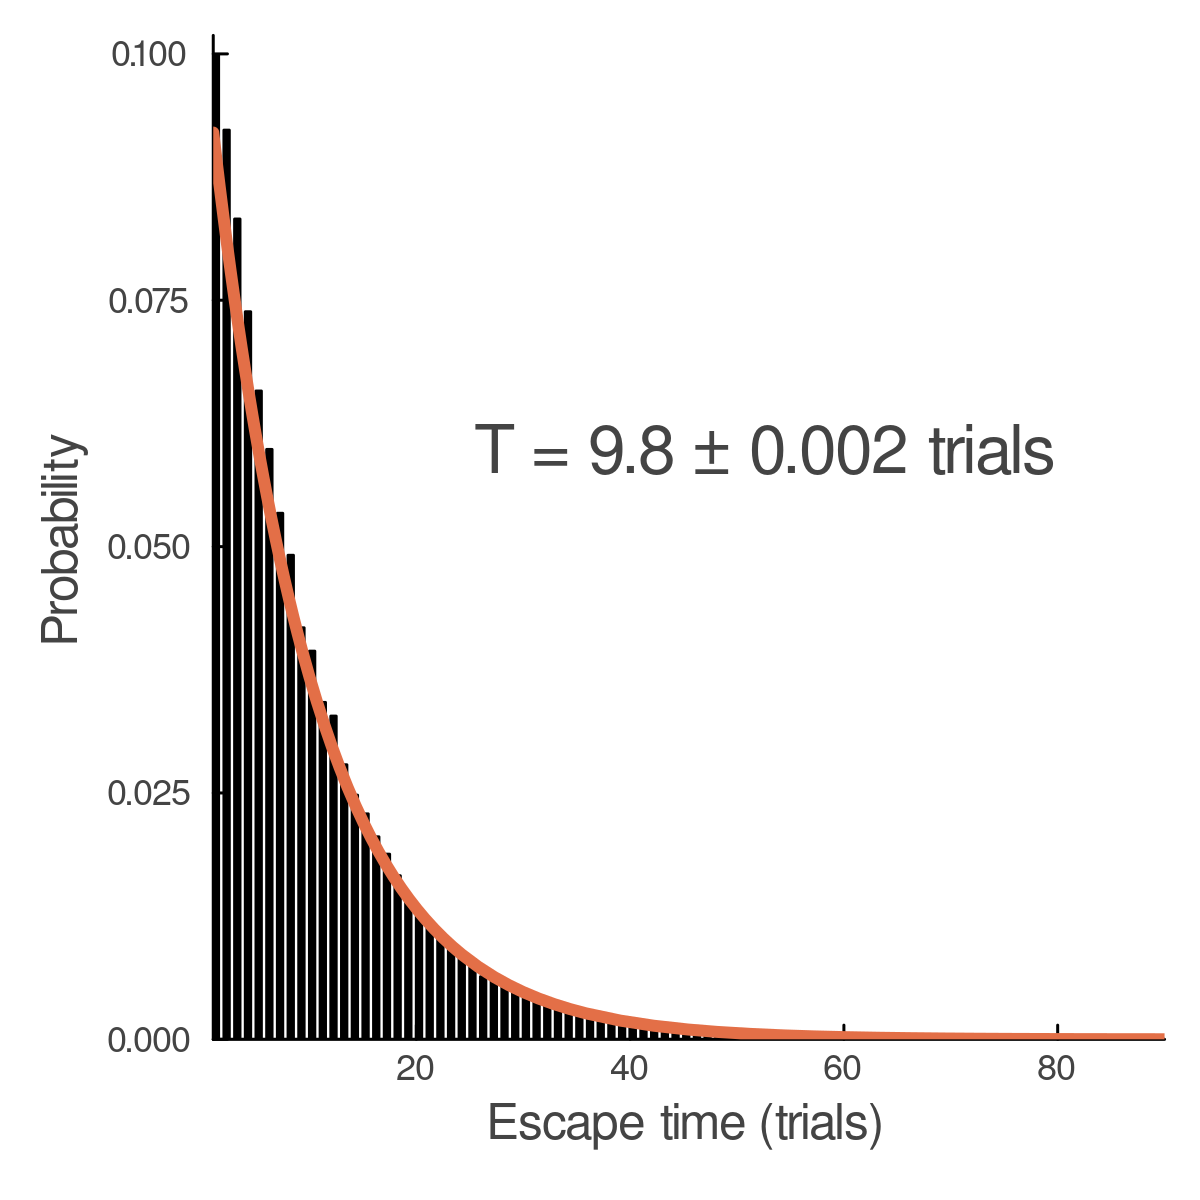

In [15]:
hmm_fixed = HMM([1,0,0],transition_matrix(est_hmm),obs_distributions(est_hmm))
N_sims = 100_000
first_escape_time = zeros(N_sims)
for i in 1:N_sims
    state_seq,_=rand(hmm_fixed, 200)
    first_escape_time[i] = findfirst(state_seq.!=1)-1
end

using Distributions
d = fit(Exponential,first_escape_time)

N_bootstrap = 1000
τ = zeros(N_bootstrap)
for i in 1:N_bootstrap
    temp = fit(Exponential,rand(first_escape_time,N_sims))
    τ[i] = temp.θ
end
mean_τ = mean(τ)
CI_τ = quantile(τ,[0.025,0.975])
SEM_τ = 2*std(τ)/sqrt(N_bootstrap)

histogram(first_escape_time,normalize=:probability,grid=false,legend=false,fontfamily="Helvetica",color=:black)
plot!(d,linewidth=4)
annotate!(80,0.06,("T = $(round(d.θ,digits=1)) ± $(round(SEM_τ,digits=3)) trials",:right,15))
xlims!(1,90)
xlabel!("Time to leave persveration state (trials)")
ylabel!("Probability")
xlabel!("Escape time (trials)")
ylabel!("Probability")
plot!(size=(400,400),dpi=300)

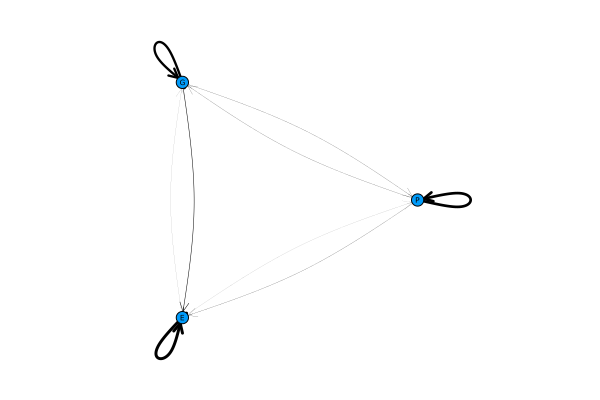

In [16]:
using Graphs, SimpleWeightedGraphs, GraphRecipes
# weighted digraph for each state, weighted by the transition probability
g = SimpleWeightedDiGraph(N_states)
for i in 1:N_states
    for j in 1:N_states
        add_edge!(g, i, j, transition_matrix(est_hmm)[i,j])
    end
end

# plot the graph
graphplot(g, names=["P","G","E"],edgewidth=3*transition_matrix(est_hmm),nodeshape=:circle,method=:circular,fontsize=5,self_edge_size=0.2,axis_buffer=0.3)

In [4]:
CSV.write(datadir("exp_pro","viterbi_states_KA.csv"),DataFrame(hcat(data,times,guess_vit),["Animal","Day","Outcome","Side","SpikeCount","Times","ViterbiGuess"]))

"z:\\justidy1\\IctalSpikeDetect_for_Maryam_manuscript\\Statistical Tests\\Hierarchical_Infer_Spikes\\data\\exp_pro\\viterbi_states_KA.csv"

## reproduces Figure 6A, but for all mice instead of just the two examples shown in the paper

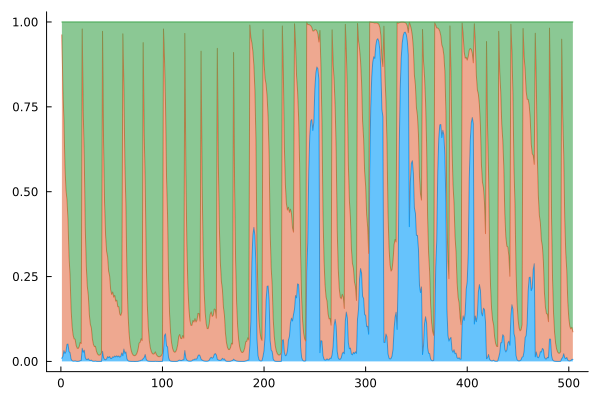

In [17]:
areaplot(1:length(guess[1,:]), guess',legend=false,fillalpha=0.6,grid=false)

In [8]:
using JLD2
jldsave(datadir("exp_pro","HMM_fit_performance_state_probs.jld2"),guess=guess)

In [18]:
using Turing

@model function DelayStateSpikes(y,t,data,states,A)
    N = length(y)
    observed_animal = data[:,1]
    # Priors
    # having a tigher prior like Normal(0.5,0.1) does not affect qualitative the results
    ρ ~ product_distribution([truncated(Normal(0.5,0.5),0,Inf) for i in 1:A]) # mean spike rate per animal, Hz, informative prior from zone model
    η ~ product_distribution([LogNormal(0,1) for i in 1:size(states,1)])
    s = tzeros(Int,N)
    # Likelihood
    for i in 1:N
        #s[i] ~ Categorical(states[:,i]) # cannot do this model, is not sampled well in terms of ess
        ρ_a = ρ[Int(observed_animal[i])]
        y[i] ~ Poisson(t[i]*ρ_a*dot(η,states[:,i]))
    end

    return y
end

model = DelayStateSpikes(data[:,5],times,data,guess,7)
chn = sample(model, NUTS(0.65),5000)

Sampling   0%|█                                         |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference C:\Users\Justin\.julia\packages\Turing\duwEY\src\mcmc\hmc.jl:212
Sampling   0%|█                                         |  ETA: 0:23:21
Sampling   1%|█                                         |  ETA: 0:11:45
Sampling   2%|█                                         |  ETA: 0:07:51
Sampling   2%|█                                         |  ETA: 0:05:55
Sampling   2%|██                                        |  ETA: 0:04:45
Sampling   3%|██                                        |  ETA: 0:03:58
Sampling   4%|██                                        |  ETA: 0:03:24
Sampling   4%|██                                        |  ETA: 0:02:59
Sampling   4%|██                                        |  ETA: 0:02:39
Sampling   5%|███                                       |  ETA: 0:02:23
Sampling   6%|███                                       |  ETA: 0:02:10
Samplin

Chains MCMC chain (5000×22×1 Array{Float64, 3}):

Iterations        = 1001:1:6000
Number of chains  = 1
Samples per chain = 5000
Wall duration     = 17.42 seconds
Compute duration  = 17.42 seconds
parameters        = ρ[1], ρ[2], ρ[3], ρ[4], ρ[5], ρ[6], ρ[7], η[1], η[2], η[3]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

        ρ[1]    0.0589    0.0142    0.0006   495.1472   554.7757    1.0013     ⋯
        ρ[2]    0.5258    0.1208    0.0056   448.9376   515.7113    1.0005     ⋯
        ρ[3]    1.1914    0.2724    0.0127   450.2902   511.7884    1.0013     ⋯
        ρ[4]    0.2298    0.0540    0.0025   467.0631   512.8544    1.0007     ⋯
        ρ[5] 

In [19]:
hpd(chn)

HPD
  parameters     lower     upper 
      Symbol   Float64   Float64 

        ρ[1]    0.0314    0.0861
        ρ[2]    0.2881    0.7510
        ρ[3]    0.6283    1.6676
        ρ[4]    0.1196    0.3282
        ρ[5]    0.1379    0.3627
        ρ[6]    0.6333    1.6317
        ρ[7]    0.0725    0.1910
        η[1]    0.5346    1.3729
        η[2]    0.2647    0.7040
        η[3]    0.5160    1.3179


# Reproduce Figure 6C

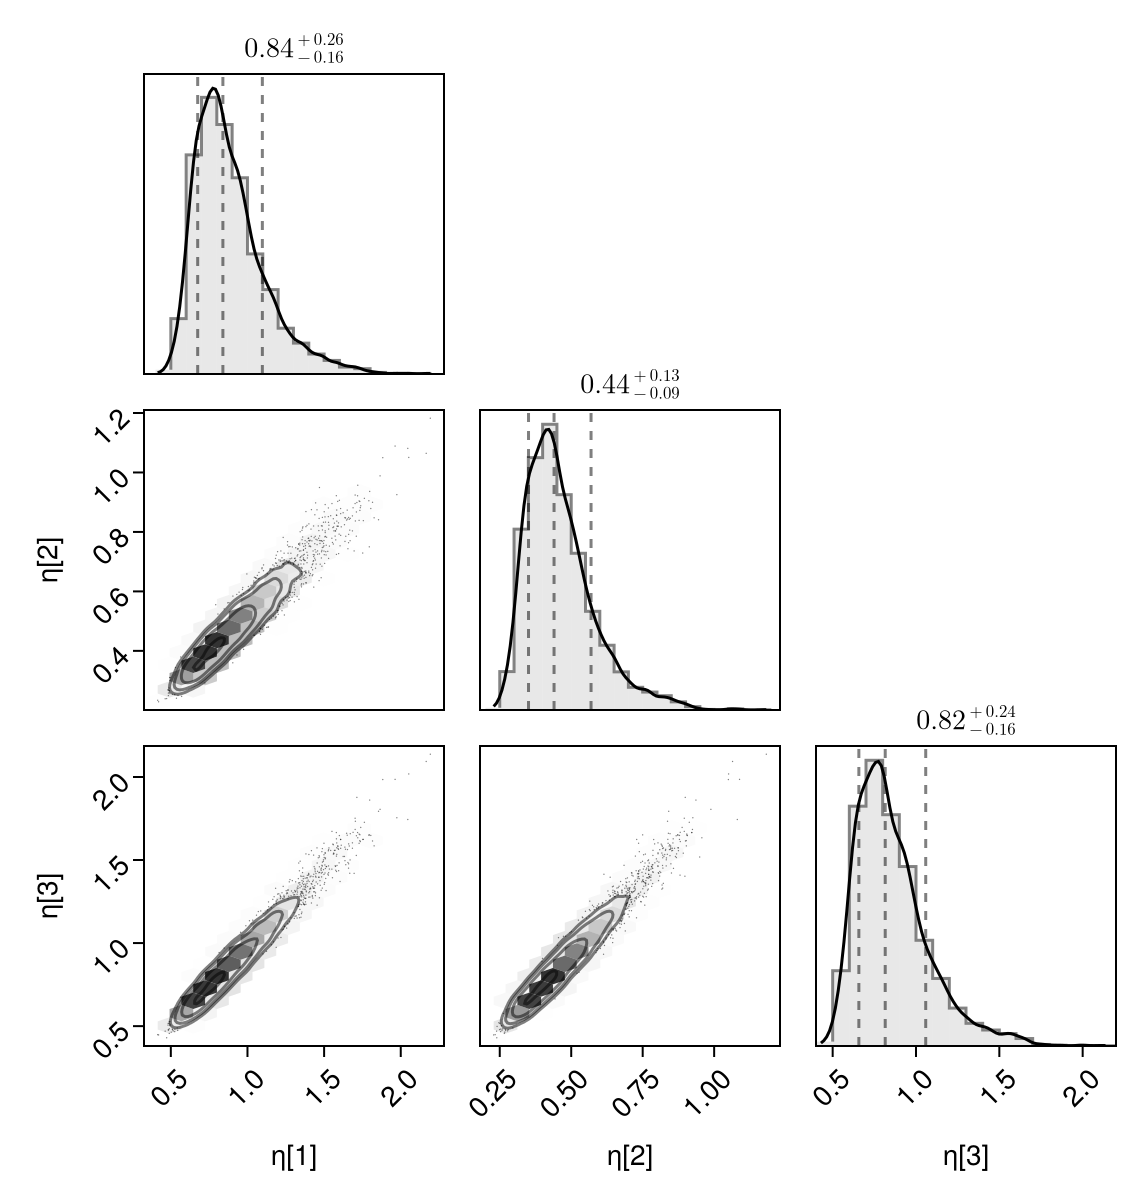

In [20]:
using CairoMakie, PairPlots
#pairplot(group(chn, :η),bodyaxis=(;limits=((0.25,1.5),(0.25,1.5))))
plt=pairplot(group(chn, :η))
#save(plotsdir("HMM_fit_pairplot.svg"),plt)

In [21]:
each_animal_posterior_mean = mean(group(chn,:ρ))[:,2]
print(mean(each_animal_posterior_mean), "+/-", 1.96*std(each_animal_posterior_mean)./sqrt(7), "\n")

0.50352437780934+/-0.3513575289528073


## Posterior predictive checks

In [22]:
using StatsBase
# https://discourse.julialang.org/t/ann-turing-0-13-0-mle-map-and-prediction/40033
# posterior predictive check
model_test = DelayStateSpikes(Vector{Union{Missing, Float64}}(undef, length(data[:,1])),times,data,guess,7)
# first sample some parameters from the posterior
predictions  = predict(model_test,chn)

Chains MCMC chain (5000×504×1 Array{Float64, 3}):

Iterations        = 1:1:5000
Number of chains  = 1
Samples per chain = 5000
parameters        = y[1], y[2], y[3], y[4], y[5], y[6], y[7], y[8], y[9], y[10], y[11], y[12], y[13], y[14], y[15], y[16], y[17], y[18], y[19], y[20], y[21], y[22], y[23], y[24], y[25], y[26], y[27], y[28], y[29], y[30], y[31], y[32], y[33], y[34], y[35], y[36], y[37], y[38], y[39], y[40], y[41], y[42], y[43], y[44], y[45], y[46], y[47], y[48], y[49], y[50], y[51], y[52], y[53], y[54], y[55], y[56], y[57], y[58], y[59], y[60], y[61], y[62], y[63], y[64], y[65], y[66], y[67], y[68], y[69], y[70], y[71], y[72], y[73], y[74], y[75], y[76], y[77], y[78], y[79], y[80], y[81], y[82], y[83], y[84], y[85], y[86], y[87], y[88], y[89], y[90], y[91], y[92], y[93], y[94], y[95], y[96], y[97], y[98], y[99], y[100], y[101], y[102], y[103], y[104], y[105], y[106], y[107], y[108], y[109], y[110], y[111], y[112], y[113], y[114], y[115], y[116], y[117], y[118], y[119], y[120], y

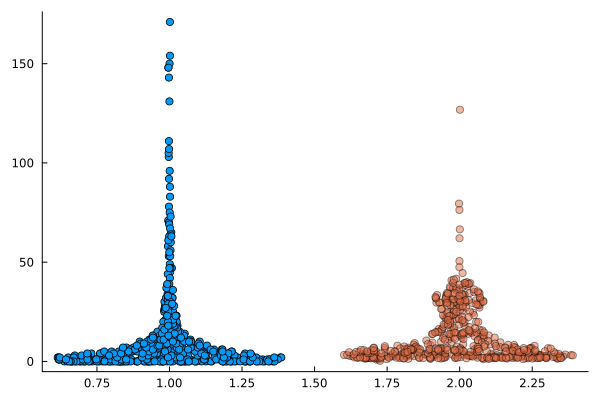

In [23]:
ys_pred = mean(predictions)[:,2]

dotplot(data[:,5],label="Observed",normalize=:pdf)
dotplot!(ys_pred,label="Mean of posterior samples",grid=false,alpha=0.5,normalize=:pdf,legend=false)

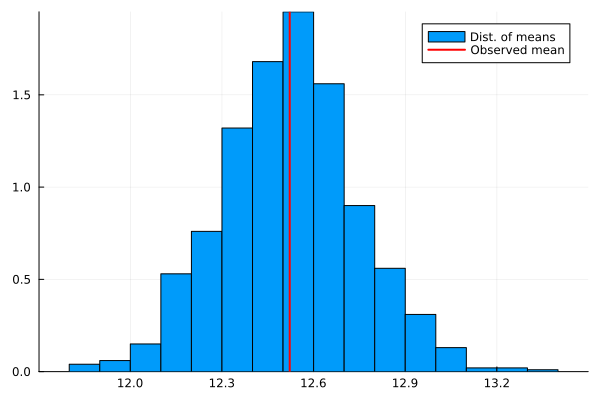

In [24]:
total_sample_means = [mean(vec(predictions[i].value.data[:,:,1])) for i in 1:1000]
histogram(total_sample_means,label="Dist. of means",normalize=:pdf)
vline!([mean(data[:,5])],label="Observed mean",color="red",linewidth=2)

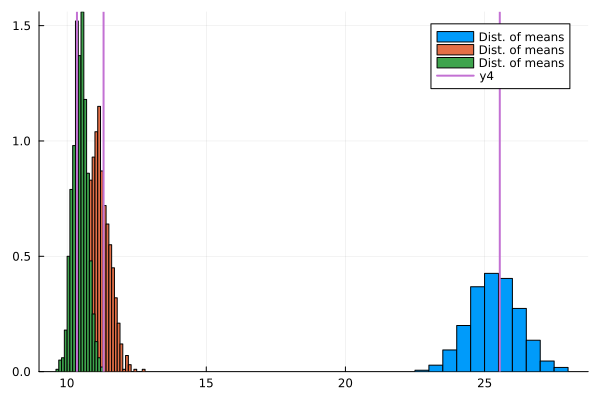

In [25]:
total_sample_means_in_each_guess_vit = [mean(vec(predictions[i].value.data)[guess_vit .== j]) for i in 1:1000, j in 1:N_states]
observed_means_in_each_guess_vit = [mean(data[guess_vit .== j,5]) for j in 1:N_states] 
histogram(total_sample_means_in_each_guess_vit,label="Dist. of means",normalize=:pdf)
vline!(observed_means_in_each_guess_vit,linewidth=2)

In [26]:
# 95% confidence intervals for the means
ci = [quantile(total_sample_means_in_each_guess_vit[:,j],[0.025,0.975]) for j in 1:N_states]

3-element Vector{Vector{Float64}}:
 [23.624609375, 27.047265625]
 [10.388690476190478, 11.89702380952381]
 [9.980812101910828, 10.968471337579619]